In [2]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### MobileNet V2 Trained by Google

In [3]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'
# 
# train_dir = 'C:/Users/Nick/Desktop/stock images/train'
# validation_dir = 'C:/Users/Nick/Desktop/stock images/validation'

In [5]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))

Found 16000 files belonging to 8 classes.
Found 16000 files belonging to 8 classes.


In [6]:
class_names = train_dataset.class_names
print(class_names)

['chan_down', 'chan_up', 'doub_bot', 'doub_top', 'hs', 'tri', 'wed_down', 'wed_up']


In [9]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 400
Number of test batches: 100


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [25]:
# Unfreeze this to train
base_model.trainable = False

# Adding a classification head using max
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_max_layer(feature_batch)
# print(feature_batch_average.shape)

# Add a dense layer to convert it to a single prediction per image
prediction_layer = tf.keras.layers.Dense(8, activation='softmax') 
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

# Process the inputs so that they are between [-1, 1] and then
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Add the preprocessing layer
x = preprocess_input(inputs)
# Add the base model after, keeping training to false
x = base_model(x, training=False)
# Add max pooling layer
x = global_max_layer(x)
# Add dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Add softmax prediction layer
outputs = prediction_layer(x)
# Create a model from inputs, outputs.
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
loss0, accuracy0 = model.evaluate(validation_dataset)

400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.1186 - loss: 4.6805


In [27]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=10,
                    validation_data=validation_dataset,
                    validation_steps=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.1010 - loss: 4.0294 - val_accuracy: 0.1375 - val_loss: 2.7893
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.1090 - loss: 3.2989 - val_accuracy: 0.1406 - val_loss: 2.6919
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.1301 - loss: 3.2664 - val_accuracy: 0.1250 - val_loss: 2.6267
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.0940 - loss: 3.1693 - val_accuracy: 0.1250 - val_loss: 2.6546
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.1122 - loss: 3.3141 - val_accuracy: 0.1000 - val_loss: 2.7314
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.1181 - loss: 3.4119 - val_accuracy: 0.1250 - val_loss: 2.6685
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.1259 - loss: 3.2602 - val_accuracy: 0.1437 - val_loss: 2.7402
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.1063 - loss: 3.4099 - val_accuracy: 0.

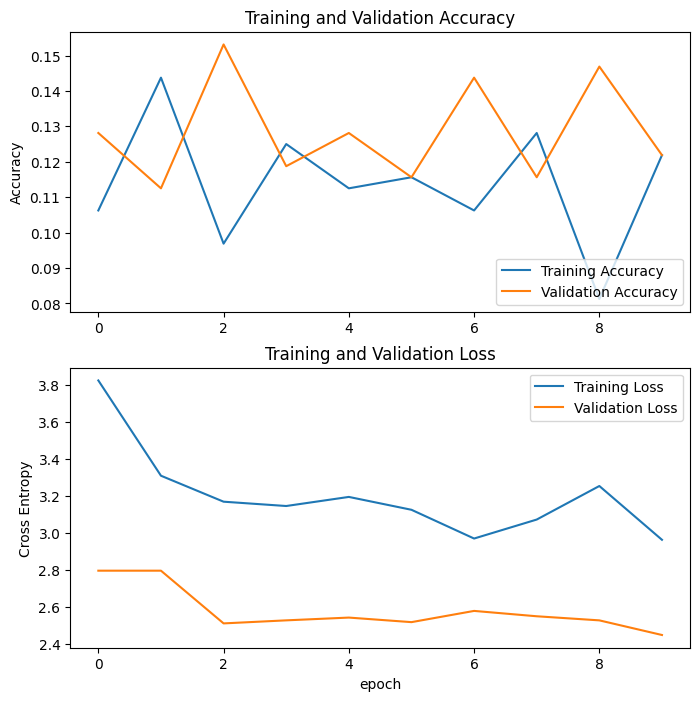

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# TODO: FINE TUNE THE MODEL
base_model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         steps_per_epoch=10,
                         validation_data=validation_dataset,
                         validation_steps=10)

Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.0868 - loss: 5.3543 - val_accuracy: 0.1531 - val_loss: 2.5706
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.1386 - loss: 4.4053 - val_accuracy: 0.0969 - val_loss: 3.0389
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.1345 - loss: 4.2774 - val_accuracy: 0.1500 - val_loss: 3.1565
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.0941 - loss: 4.1563 - val_accuracy: 0.1312 - val_loss: 3.1203
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.0962 - loss: 4.2768 - val_accuracy: 0.1063 - val_loss: 2.9469
Epoch 16/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.1209 - loss: 4.1937 - val_accuracy: 0.1344 - val_loss: 2.8119
Epoch 17/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.0996 - loss: 4.0906 - val_accuracy: 0.1156 - val_loss: 2.8088
Epoch 18/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.1150 - loss: 4.1730 - val_acc

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

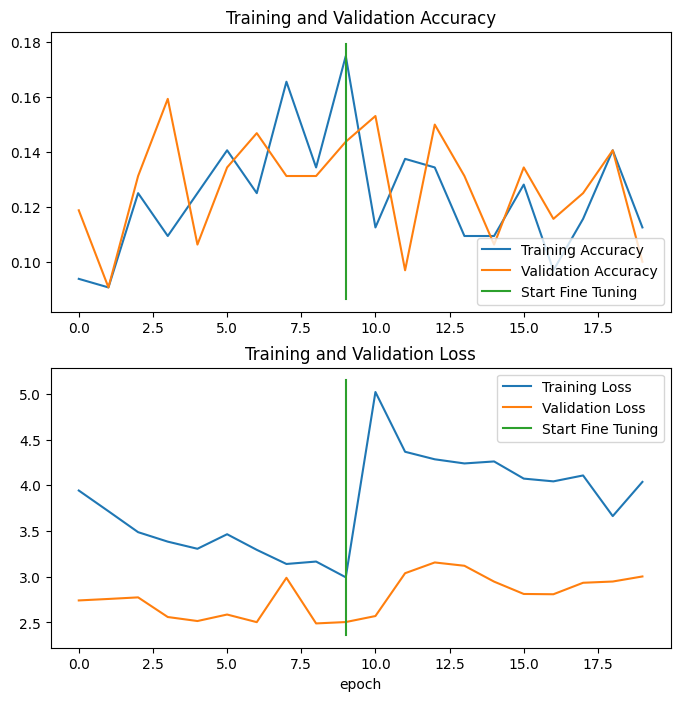

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.1181 - loss: 2.9394
Test accuracy : 0.12687499821186066


In [67]:
class_names = train_dataset.class_names

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

array([0.2512615 , 0.10064583, 0.07594016, 0.06436457, 0.08116884],
      dtype=float32)

In [71]:
# Apply a sigmoid since our model returns logits
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.softmax(predictions, axis=-1)
predictions

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([0.00439137, 0.00377736, 0.00368518, 0.00364277, 0.0037045 ,
       0.00386396, 0.00379369, 0.00416504, 0.00538072, 0.00354438,
       0.00359795, 0.00362901, 0.0036073 , 0.00363969, 0.00375256,
       0.00410508, 0.00429048, 0.00368693, 0.00376538, 0.00375128,
       0.00372322, 0.00378782, 0.00392274, 0.00407439, 0.00484489,
       0.00359642, 0.00364592, 0.00367151, 0.00370464, 0.00369365,
       0.00383443, 0.00411538, 0.00559158, 0.00352309, 0.00358094,
       0.00360627, 0.00357758, 0.00362159, 0.00371279, 0.00411545,
       0.00528375, 0.00353621, 0.00359102, 0.00362399, 0.00364302,
       0.00366366, 0.00374668, 0.004142  , 0.00570021, 0.00351674,
       0.00355173, 0.00359299, 0.00363292, 0.00362907, 0.00368177,
       0.00405588, 0.00655904, 0.00344612, 0.00343998, 0.00346507,
       0.00347799, 0.00355393, 0.00348389, 0.0043409 , 0.00443457,
       0.00346795, 0.00417163, 0.00369019, 0.00343101, 0.0041916 ,
       0.00347

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [6 2 0 4 3 7 2 5 1 2 5 6 4 2 2 0 4 2 7 1 3 4 4 7 5 3 3 7 5 1 6 5]


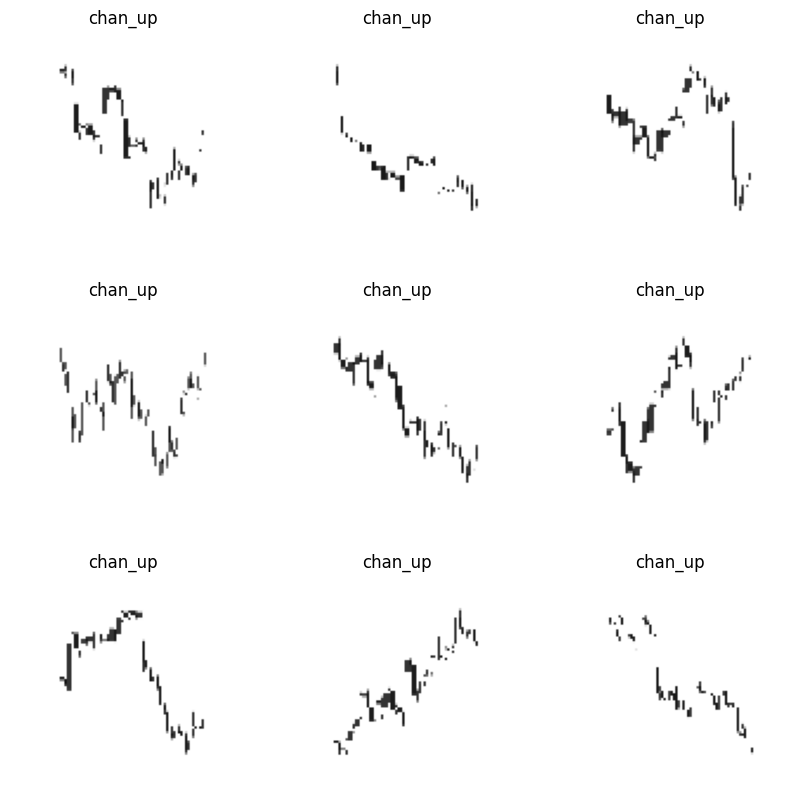

In [59]:

predictions = tf.where(predictions < 0.5, 0, 1)



print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")